# Model 2: Using CNN's with the Skin Condition Dataset

For the first model we will use the skin condition dataset to train a model that can classify 5 skin condition. For this, we will create own Convolutional Neural Network in Tensorflow and leverage Keras' image preprocessing utilities.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Install Required Libraries

Before we proceed with dataset, let's first install the required libraries to ensure everything is set up correctly for the next steps.

In [ ]:
import os
import pickle
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

Since we have already installed the required libraries, we can now proceed to the next step, which is **Pre-Processing the Dataset**.

<a name="2"></a>
## Pre-Processing the Dataset

Let's explore the dataset in the folder `./SkinCondition`. There is a subdirectory for each skin condition class, which consists of images representing various conditions, namely acne, dark spots, large pores, normal skin, and wrinkles. The complete directory tree looks like this:

```
.
└── SkinCondition/
    ├── acne/
    │   ├── acne_1.jpg
    │   ├── acne_2.jpg
    │   └── ...
    └── dark spot/
        ├── darkspot_1.jpg
        ├── darkspot_2.jpg
    |   └── ...
    └── large pores/
        ├── largepores_1.jpg
        ├── largepores_2.jpg
    |   └── ...
    └── normal/
        ├── normal_1.jpg
        ├── normal_2.jpg
    |   └── ...
    └── wrinkles/
        ├── wrinkles_1.jpg
        ├── wrinkles_2.jpg
        └── ...

```

### Load Image

Before we begin building the model, let's load an image to explore it's content and understand it's properties. This will help us get a clearer idea of the data we're working with and ensure that we can process the images correctly for the next steps.

In [ ]:
DATA_DIR = '/content/drive/My Drive/Skin Condition/SkinCondition'

data_dir_acne = os.path.join(DATA_DIR, 'acne')
data_dir_darkspot = os.path.join(DATA_DIR, 'dark spot')
data_dir_largepores = os.path.join(DATA_DIR, 'large pores')
data_dir_wrinkles = os.path.join(DATA_DIR, 'wrinkles')
data_dir_normal = os.path.join(DATA_DIR, 'normal')

print(f"There are {len(os.listdir(data_dir_acne))} images of acne.")
print(f"There are {len(os.listdir(data_dir_darkspot))} images of dark spot.")
print(f"There are {len(os.listdir(data_dir_largepores))} images of large pores.")
print(f"There are {len(os.listdir(data_dir_wrinkles))} images of wrinkles.")
print(f"There are {len(os.listdir(data_dir_normal))} images of normal.")

There are 320 images of acne.
There are 330 images of dark spot.
There are 320 images of large pores.
There are 320 images of wrinkles.
There are 320 images of normal.


While it's useful to know the number of images in each class, let's visualize a few of them to gain a clearer understanding of the types of images in the dataset:

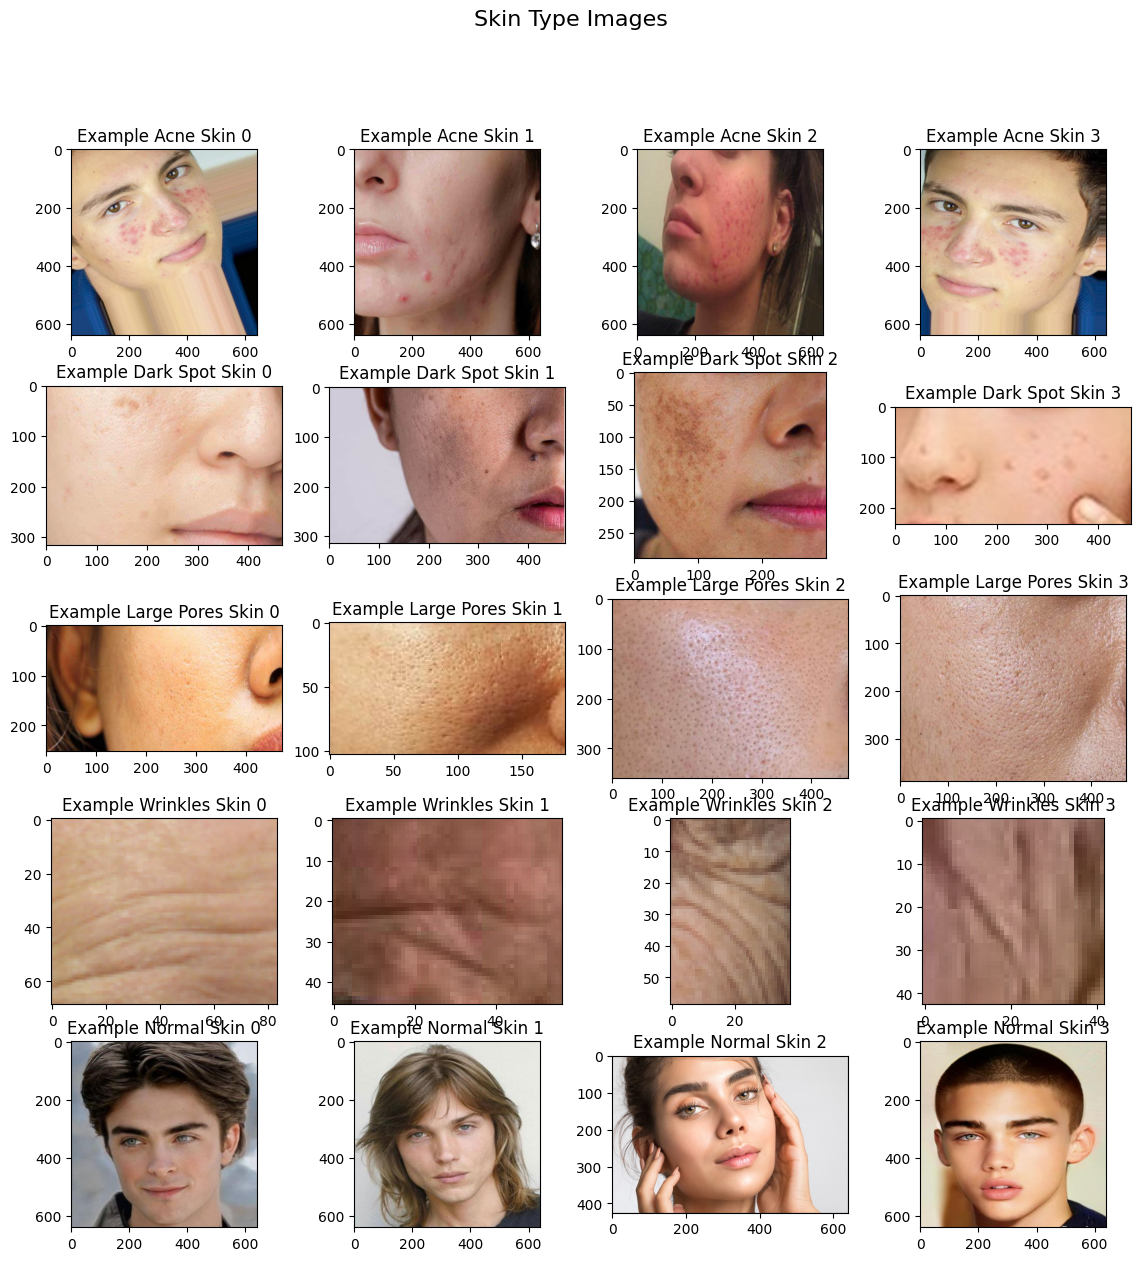

In [ ]:
acne_filenames = [os.path.join(data_dir_acne, filename) for filename in os.listdir(data_dir_acne)]
darkspot_filenames = [os.path.join(data_dir_darkspot, filename) for filename in os.listdir(data_dir_darkspot)]
largepores_filenames = [os.path.join(data_dir_largepores, filename) for filename in os.listdir(data_dir_largepores)]
wrinkles_filenames = [os.path.join(data_dir_wrinkles, filename) for filename in os.listdir(data_dir_wrinkles)]
normal_filenames = [os.path.join(data_dir_normal, filename) for filename in os.listdir(data_dir_normal)]

num_examples = 4

random_acne = random.sample(acne_filenames, num_examples)
random_darkspot = random.sample(darkspot_filenames, num_examples)
random_largepores = random.sample(largepores_filenames, num_examples)
random_wrinkles = random.sample(wrinkles_filenames, num_examples)
random_normal = random.sample(normal_filenames, num_examples)

fig, axes = plt.subplots(5, num_examples, figsize=(14, 14))
fig.suptitle('Skin Type Images', fontsize=16)

for i, acne_image in enumerate(random_acne):
    img = tf.keras.utils.load_img(acne_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Acne Skin {i}')

for i, darkspot_image in enumerate(random_darkspot):
    img = tf.keras.utils.load_img(darkspot_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Dark Spot Skin {i}')

for i, largepores_image in enumerate(random_largepores):
    img = tf.keras.utils.load_img(largepores_image)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f'Example Large Pores Skin {i}')

for i, wrinkles_image in enumerate(random_wrinkles):
    img = tf.keras.utils.load_img(wrinkles_image)
    axes[3, i].imshow(img)
    axes[3, i].set_title(f'Example Wrinkles Skin {i}')

for i, normal_image in enumerate(random_normal):
    img = tf.keras.utils.load_img(normal_image)
    axes[4, i].imshow(img)
    axes[4, i].set_title(f'Example Normal Skin {i}')
plt.show()

These example images from each skin condition class are certainly interesting! Notice that these images come in all kinds of resolutions!

### Split Dataset

Once we have loaded the images, the next step is to split the dataset into training and validation sets. This split ensures that we can train our model on one portion of the data while using another portion to evaluate its performance.

In [ ]:
def train_val_datasets():
    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory= DATA_DIR,
        image_size=(120, 120),
        batch_size=128,
        label_mode='categorical',
        validation_split=0.20,
        subset='both',
        seed=42
    )

    return training_dataset, validation_dataset

In [ ]:
training_dataset, validation_dataset = train_val_datasets()

Found 1578 files belonging to 5 classes.
Using 1263 files for training.
Using 315 files for validation.


At this point, we now have two separate datasets, one dedicated to training the model and the other for validating its performance.

The training dataset will be used to teach the model to recognize patterns and make predictions, while the validation dataset will allow we to assess how well the model generalizes to new, unseen data, helping to fine-tune the model and avoid overfitting.

In [ ]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 120, 120, 3)
Shape of batch of labels: (128, 5)


Keep in mind that the pixel values of the images are not normalized yet, so we need to add a Rescaling layer in the model to scale these values by a factor of 1./255.

### Data Augmentation

With the data in the approciate format, the next step is to apply data augmentation to enhance the model's robustness by creating varied image versions through transformations such as rotation, flipping, scaling, or color adjustments.

In [ ]:
def create_augmentation_model():

    augmentation_model = tf.keras.Sequential([
        tf.keras.Input(shape=(120, 120, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="nearest"),
        tf.keras.layers.RandomZoom(0.1, fill_mode="nearest"),
        tf.keras.layers.RandomContrast(0.1),
    ])
    return augmentation_model

In [ ]:
def demo_augmentation(sample_image, model, num_aug):

    image_preview = []

    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    image_preview.append(sample_image_pil)

    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

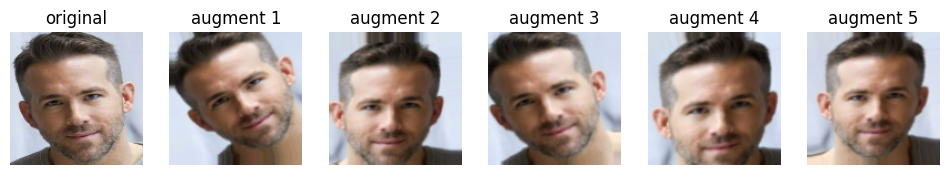

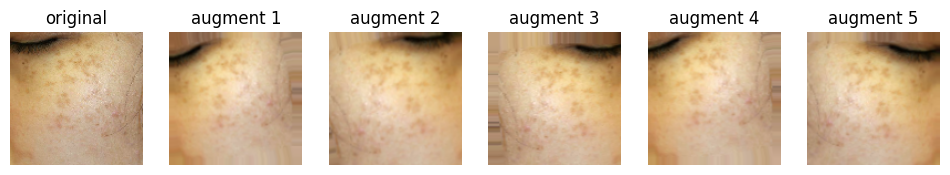

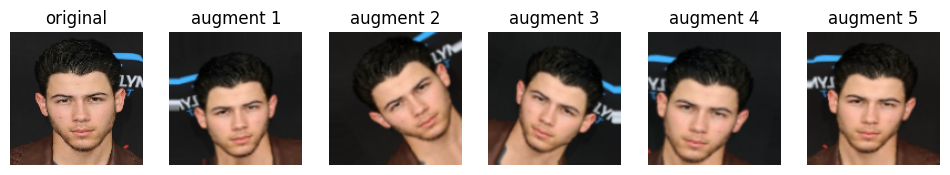

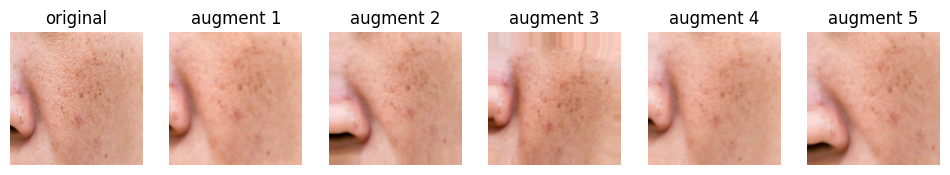

In [ ]:
NUM_AUG = 5

sample_batch = list(training_dataset.take(1))[0][0]

demo_augmentation(sample_batch[0], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[1], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[2], create_augmentation_model(), NUM_AUG)
demo_augmentation(sample_batch[3], create_augmentation_model(), NUM_AUG)

del sample_batch

## Build and Train The Model

After completing the pre-processing steps, we will proceed by building model from scratch using Convolutional Neural Network.

In [ ]:
def create_model():
    augmentation_layers = create_augmentation_model()

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(120, 120, 3)),
        augmentation_layers,

        tf.keras.layers.Rescaling(1./255),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),

        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = create_model()
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 120, 120, 3)
Output shape: (None, 5)



The next cell allows us to examine the total number of parameters in the model.

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 118, 118, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 57, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,862,917 (10.92 MB)

 Trainable params: 2,862,917 (10.92 MB)

 Non-trainable params: 0 (0.00 B)

Now, we can begin training the model. We will use 100 epochs for the training process.

In [ ]:
history = model.fit(
	training_dataset,
	epochs=100,
	validation_data=validation_dataset,
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.4424 - loss: 1.2811 - val_accuracy: 0.4603 - val_loss: 1.1677
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 549ms/step - accuracy: 0.3979 - loss: 1.3171 - val_accuracy: 0.4508 - val_loss: 1.1916
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 537ms/step - accuracy: 0.4445 - loss: 1.2324 - val_accuracy: 0.4286 - val_loss: 1.2313
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - accuracy: 0.4506 - loss: 1.2542 - val_accuracy: 0.5429 - val_loss: 1.1349
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 645ms/step - accuracy: 0.5307 - loss: 1.1714 - val_accuracy: 0.4794 - val_loss: 1.2206
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 577ms/step - accuracy: 0.5224 - loss: 1.1488 - val_accuracy: 0.5270 - val_loss: 1.1322
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 527ms/step - accuracy: 0.5462 - loss: 1.1304 - val_accuracy: 0.5683 - val_loss: 1.0633
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 675ms/step - accuracy: 0.5561 - loss: 1.0909 - val_

The following code will display the training and validation accuracy achieved at the end of each epoch once the training is complete.

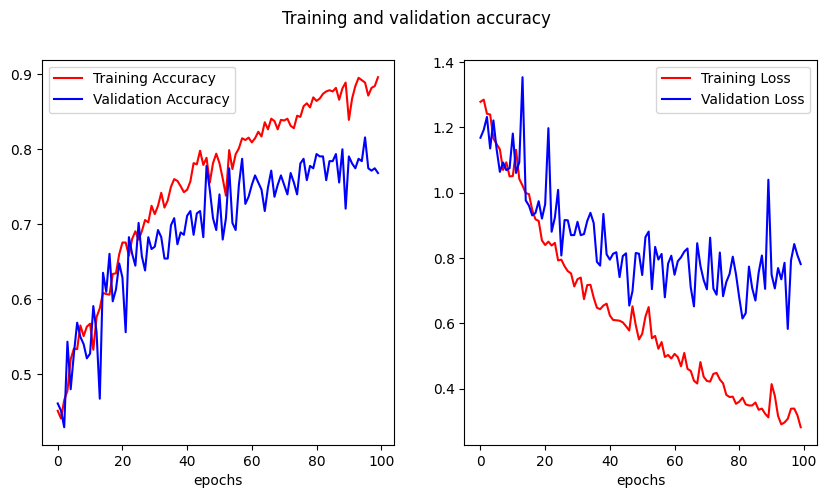

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

Finally! We have successfully built and trained model from scratch using Convolutional Neural Network.